In [2]:
import os
if 'uk' in os.getcwd():
    os.chdir("../..")
os.getcwd()

'/Users/user/Documents/GitHub/covid-19-in-households-public'

In [39]:
'''This runs the UK-like model with a single set of parameters for 100 days
'''
from copy import deepcopy
from numpy import arange, array, atleast_2d, diag, eye, hstack, ix_, log, ones, sum, where, zeros
from numpy import int64 as my_int
from numpy.linalg import eig
from os import mkdir
from os.path import isdir, isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.sparse import csc_matrix as sparse
from model.preprocessing import ( calculate_sitp_rmse, estimate_beta_ext, estimate_growth_rate,
        SEIRInput, HouseholdPopulation, ModelInput, make_initial_condition_by_eigenvector)
from model.specs import SINGLE_AGE_SEIR_SPEC_FOR_FITTING, SINGLE_AGE_UK_SPEC
from model.common import RateEquations
from model.imports import NoImportModel
from model.subsystems import build_state_matrix, inf_events, progression_events, subsystem_key
# pylint: disable=invalid-name

First make functions for SEIRV model. Note that there are no extra transition rates for the SEIRV model because we assume vaccination is a discrete timed event rather than continuous.

In [40]:


def _seirv_subsystem(self, household_spec):
    '''This function processes a composition to create subsystems i.e.
    matrices and vectors describing all possible epdiemiological states
    for a given household composition
    Assuming frequency-dependent homogeneous within-household mixing
    composition[i] is the number of individuals in age-class i inside the
    household'''

    no_compartments = household_spec.no_compartments

    s_comp, e_comp, i_comp, r_comp, v_comp = range(no_compartments)

    composition = household_spec.composition
    matrix_shape = household_spec.matrix_shape
    sus = self.model_input.sus
    K_home = self.model_input.k_home
    alpha = self.model_input.alpha
    gamma = self.model_input.gamma
    density_expo = self.model_input.density_expo

    # Set of individuals actually present here
    class_idx = household_spec.class_indexes

    K_home = K_home[ix_(class_idx, class_idx)]
    sus = sus[class_idx]
    r_home = atleast_2d(diag(sus).dot(K_home))

    states, \
        reverse_prod, \
        index_vector, \
        rows = build_state_matrix(household_spec)

    Q_int = sparse(household_spec.matrix_shape,)
    inf_event_row = array([], dtype=my_int)
    inf_event_col = array([], dtype=my_int)
    inf_event_class = array([], dtype=my_int)

    Q_int, inf_event_row, inf_event_col, inf_event_class = inf_events(s_comp,
                e_comp,
                [i_comp],
                [ones(len(class_idx))],
                r_home,
                density_expo,
                no_compartments,
                composition,
                states,
                index_vector,
                reverse_prod,
                class_idx,
                matrix_shape,
                Q_int,
                inf_event_row,
                inf_event_col,
                inf_event_class)
    Q_int = progression_events(e_comp,
                    i_comp,
                    alpha,
                    no_compartments,
                    states,
                    index_vector,
                    reverse_prod,
                    class_idx,
                    matrix_shape,
                    Q_int)
    Q_int = progression_events(i_comp,
                    r_comp,
                    gamma,
                    no_compartments,
                    states,
                    index_vector,
                    reverse_prod,
                    class_idx,
                    matrix_shape,
                    Q_int)

    S = Q_int.sum(axis=1).getA().squeeze()
    Q_int += sparse((
        -S, (
            arange(household_spec.total_size),
            arange(household_spec.total_size)
        )))
    return tuple((
        Q_int,
        states,
        array(inf_event_row, dtype=my_int, ndmin=1),
        array(inf_event_col, dtype=my_int, ndmin=1),
        array(inf_event_class, dtype=my_int, ndmin=1),
        reverse_prod,
        index_vector))
    
subsystem_key["SEIRV"] = [_seirv_subsystem, 5, [2], 1]

class SEIRVInput(ModelInput):
    def __init__(self, spec, composition_list, composition_distribution, print_ests=True):
        super().__init__(spec, composition_list, composition_distribution)

        self.expandables = ['sus',
                            'inf_scales']

        self.R_compartment = 3

        self.sus = spec['sus']
        self.inf_scales = [ones((self.no_age_classes,))]
        self.gamma = self.spec['recovery_rate']

        self.ave_trans = 1 / self.gamma

        self.prog_rates = array([self.gamma])

        def sitp_rmse(x):
            return calculate_sitp_rmse(x, self, spec['SITP'])

        pars = minimize(sitp_rmse, array([1e-1,1]), bounds=((0,None),(0,1))).x
        self.pars = pars
        self.beta_int = pars[0]
        self.density_expo = pars[1]
        if print_ests:
            print('Estimated beta_int=',pars[0],', estimated density=',pars[1])

        self.k_home = self.beta_int * self.k_home

        ext_eig = max(eig(
            diag(self.sus).dot((1/spec['recovery_rate']) *
             (self.k_ext).dot(diag(self.inf_scales[0])))
            )[0])
        if spec['fit_method'] == 'R*':
            external_scale = spec['R*'] / (self.ave_hh_size*spec['SITP'])
        else:
            external_scale = 1
        self.k_ext = external_scale * self.k_ext / ext_eig

    @property
    def alpha(self):
        return self.spec['incubation_rate']

class SEIRVRateEquations(RateEquations):
    @property
    def states_exp_only(self):
        return self.household_population.states[:, 1::self.no_compartments]

    @property
    def states_inf_only(self):
        return self.household_population.states[:, 2::self.no_compartments]

    @property
    def states_rec_only(self):
        return self.household_population.states[:, 3::self.no_compartments]

    @property
    def states_vacc_only(self):
        return self.household_population.states[:, 4::self.no_compartments]

In [42]:
SINGLE_AGE_SEIRV_SPEC = deepcopy(SINGLE_AGE_SEIR_SPEC_FOR_FITTING)
SINGLE_AGE_SEIRV_SPEC['compartmental_structure'] = "SEIRV"

if isdir('outputs/uk') is False:
    mkdir('outputs/uk')

DOUBLING_TIME = 3
growth_rate = log(2) / DOUBLING_TIME

comp_dist = read_csv(
    'inputs/england_hh_size_dist.csv',
    header=0).to_numpy().squeeze()
comp_dist = comp_dist[:6]
comp_dist[:5] *= 0
comp_dist = comp_dist/sum(comp_dist)
max_hh_size = len(comp_dist)
composition_list = atleast_2d(arange(1, max_hh_size+1)).T

SPEC = {**SINGLE_AGE_SEIRV_SPEC, **SINGLE_AGE_UK_SPEC}
model_input_to_fit = SEIRVInput(SPEC, composition_list, comp_dist)
household_population_to_fit = HouseholdPopulation(
    composition_list, comp_dist, model_input_to_fit)
beta_ext = 3.
model_input = deepcopy(model_input_to_fit)
model_input.k_ext *= beta_ext


# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input)

rhs = SEIRVRateEquations(model_input, household_population, NoImportModel(4, 1))

#r_est = estimate_growth_rate(household_population, rhs, [0.001, 5], 1e-9)


#print('Estimated growth rate is',r_est,'.')
#print('Estimated doubling time is',log(2) / r_est,'.')

H0 = zeros((household_population.total_size),)
all_sus = where(sum(rhs.states_exp_only + rhs.states_inf_only + rhs.states_rec_only + rhs.states_vacc_only, 1)<1e-1)[0]
one_inf = where((abs(sum(rhs.states_inf_only, 1) - 1)<1e-1) & (sum(rhs.states_exp_only + rhs.states_rec_only + rhs.states_vacc_only, 1)<1e-1))[0]
H0[all_sus] = 0.99 * comp_dist
H0[one_inf] = 0.01 * comp_dist
S0 = H0.T.dot(household_population.states[:, ::5])
E0 = H0.T.dot(household_population.states[:, 1::5])
I0 = H0.T.dot(household_population.states[:, 2::5])
R0 = H0.T.dot(household_population.states[:, 3::5])
start_state = (1/model_input.ave_hh_size) * array([S0.sum(),
                                                   E0.sum(),
                                                   I0.sum(),
                                                   R0.sum()])
tspan = (0.0, 365)
print(start_state)

Estimated beta_int= 0.009247625935219963 , estimated density= 0.5452964327371987
[0.99833333 0.         0.00166667 0.        ]


In [44]:
wkly_uptake = 1e-1 # Assume each week 1% take vaccine
flat_vacc_map = eye((len(rhs.states_sus_only)))
no_compartments = 3
from_compartment = 0
to_compartment = 4

from_present = \
    where(household_population.states[:, from_compartment] > 0)[0]

prog_to = zeros(len(from_present), dtype=my_int)
prog_rate = zeros(len(from_present))
for k in range(len(from_present)):
    old_state = deepcopy(household_population.states[from_present[k], :])
    prog_rate[k] = \
        wkly_uptake
    new_state = deepcopy(old_state)
    new_state[from_compartment] -= 1
    new_state[to_compartment] += 1
    prog_to[k] = where(sum(abs(household_population.states - new_state), 1) < 1e-1)[0]
    flat_vacc_map[from_present[k], prog_to[k]] = prog_rate[k]
    flat_vacc_map[from_present[k], from_present[k]] = (1-prog_rate[k])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/3086965960.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prog_to[k] = where(sum(abs(household_population.states - new_state), 1) < 1e-1)[0]


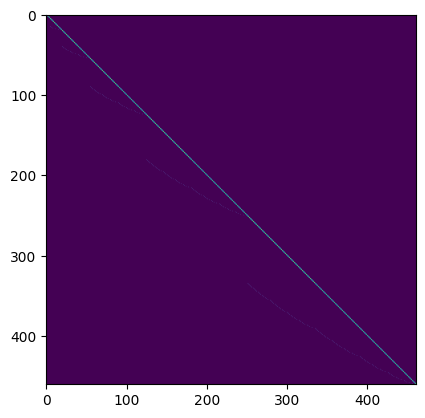

In [45]:
from matplotlib.pyplot import subplots

fig, ax = subplots(1, 1)
ax.imshow(flat_vacc_map)

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/1776546965.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prog_to[k] = where(sum(abs(household_population.states - new_state), 1) < 1e-1)[0]


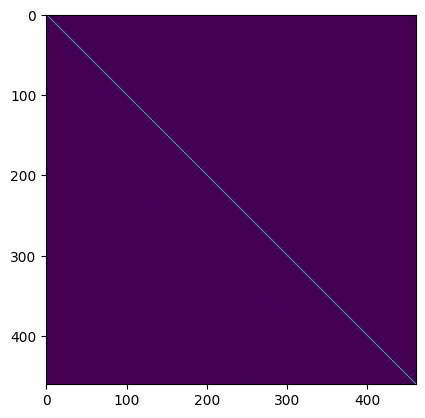

In [86]:
hh_vacc_map = eye((len(rhs.states_sus_only)))

prog_to = zeros(household_population.total_size, dtype=my_int)
prog_rate = zeros(household_population.total_size,)
for k in range(len(household_population.states)):
    old_state = deepcopy(household_population.states[k, :])
    prog_rate[k] = wkly_uptake * (1/household_population.hh_size_by_state[k])
    new_state = deepcopy(old_state)
    new_state[from_compartment] = 0
    new_state[to_compartment] += old_state[from_compartment]
    prog_to[k] = where(sum(abs(household_population.states - new_state), 1) < 1e-1)[0]
    hh_vacc_map[k, prog_to[k]] = prog_rate[k]
    hh_vacc_map[k, k] = (1-prog_rate[k])

fig, ax = subplots(1, 1)
ax.imshow(hh_vacc_map)

In [108]:
def simulate_flat_wkly_vacc(no_wks):
    Ht = deepcopy(H0)
    H_all = atleast_2d(deepcopy(H0)).T
    t_all = array(0)
    doses = array(0)
    for wk in range(no_wks):
        tspan = (wk*7, (wk+1)*7)
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        Ht = H[:, -1]
        Ht_v = flat_vacc_map.T.dot(Ht)
        dV = Ht_v.T.dot(household_population.states[:, 4::5]) - Ht.T.dot(household_population.states[:, 4::5])
        doses = hstack((doses, array(dV)))
        Ht = Ht_v
        Ht = Ht/sum(Ht)
        H_all = hstack((H_all, H))
        t_all = hstack((t_all, time))
    doses = cumsum(doses)
    return(H_all, t_all, doses)
    

In [109]:
H_flat, t_flat, doses_flat = simulate_flat_wkly_vacc(12)

In [110]:
S = H_flat.T.dot(household_population.states[:, ::5])
E = H_flat.T.dot(household_population.states[:, 1::5])
I = H_flat.T.dot(household_population.states[:, 2::5])
R = H_flat.T.dot(household_population.states[:, 3::5])
V = H_flat.T.dot(household_population.states[:, 4::5])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/631082809.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


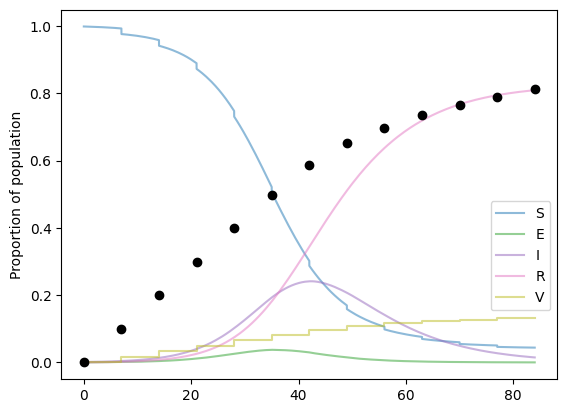

In [112]:
from matplotlib.cm import get_cmap
from numpy import cumsum

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class,
    V/model_input.ave_hh_by_class]

lgd=['S','E','I','R', 'V']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(
        t_flat, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.plot(arange(0, 13*7, 7), doses_flat, "ko")
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [117]:
def simulate_hh_wkly_vacc(no_wks):
    Ht = deepcopy(H0)
    H_all = atleast_2d(deepcopy(H0)).T
    t_all = array(0)
    doses = array(0)
    for wk in range(no_wks):
        tspan = (wk*7, (wk+1)*7)
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        Ht = H[:, -1]
        Ht_v = hh_vacc_map.T.dot(Ht)
        dV = Ht_v.T.dot(household_population.states[:, 4::5]) - Ht.T.dot(household_population.states[:, 4::5])
        doses = hstack((doses, array(dV)))
        Ht = Ht_v
        Ht = Ht/sum(Ht)
        H_all = hstack((H_all, H))
        t_all = hstack((t_all, time))
    doses = cumsum(doses)
    return(H_all, t_all, doses)

In [118]:
H_hh, t_hh, doses_hh = simulate_hh_wkly_vacc(12)

S = H_hh.T.dot(household_population.states[:, ::5])
E = H_hh.T.dot(household_population.states[:, 1::5])
I = H_hh.T.dot(household_population.states[:, 2::5])
R = H_hh.T.dot(household_population.states[:, 3::5])
V = H_hh.T.dot(household_population.states[:, 4::5])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/1225641148.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


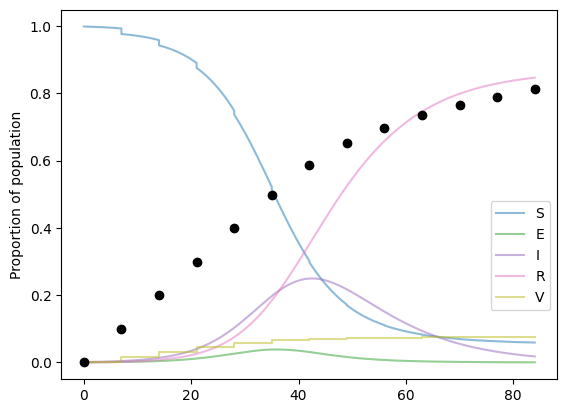

In [119]:
data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class,
    V/model_input.ave_hh_by_class]

lgd=['S','E','I','R','V']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(
        t_hh, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.plot(arange(0, 13*7, 7), doses_flat, "ko")
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/256709456.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


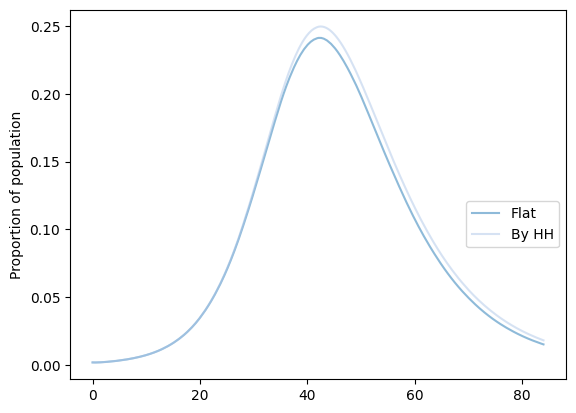

In [81]:
I_flat = H_flat.T.dot(household_population.states[:, 2::5])/model_input.ave_hh_by_class
I_hh = H_hh.T.dot(household_population.states[:, 2::5])/model_input.ave_hh_by_class

lgd=['Flat', 'By HH']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
axis.plot(t_flat, I_flat, label=lgd[0],
        color=cmap(0, alpha=alpha))
axis.plot(t_hh, I_hh, label=lgd[1],
        color=cmap(1, alpha=alpha))
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_60098/1211386106.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


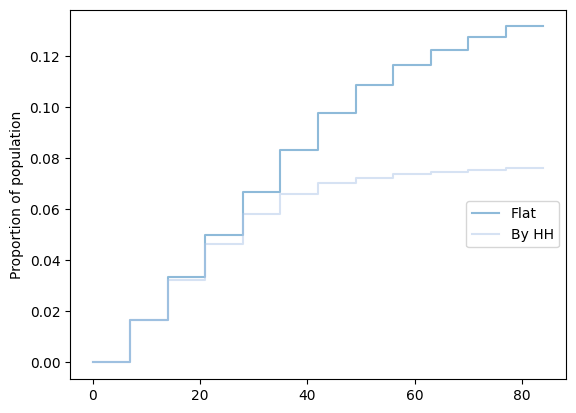

In [82]:
V_flat = H_flat.T.dot(household_population.states[:, 4])/model_input.ave_hh_by_class
V_hh = H_hh.T.dot(household_population.states[:, 4])/model_input.ave_hh_by_class

lgd=['Flat', 'By HH']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
axis.plot(t_flat, V_flat, label=lgd[0],
        color=cmap(0, alpha=alpha))
axis.plot(t_hh, V_hh, label=lgd[1],
        color=cmap(1, alpha=alpha))
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))